In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from wiki_nlp.data.dataset import WikiDataset, WikiExample
from wiki_nlp.models.dm import DM
from wiki_nlp.models.som import SOM

In [2]:
dataset = torch.load("document_dataset")
model_state = torch.load("document_dm_state")
model = DM(embedding_dim=100, n_docs=len(dataset), n_words=len(dataset.vocab))
model.load_state_dict(model_state['model_state_dict'])
x = model._D[:-1].detach()

In [3]:
grid_x = 25
grid_y = 25 
som = SOM(x_size=grid_x, y_size=grid_y, w_size=100)
epochs = 5000 

In [4]:
def train_som(som: SOM, x: torch.FloatTensor, epochs: int):
    for i in range(0, epochs):
        for j, s in enumerate(x):
            neigh, _ = som.forward(s, i)
            som.backward(s, neigh, i)
    
    winner_coordinates = torch.tensor([som.winner(d) for d in x]).T
    return winner_coordinates

In [5]:
winners = train_som(som, x, epochs)
winners = winners.detach().numpy()

In [6]:
cluster_index = np.ravel_multi_index(winners, (25, 25))

In [7]:
def distance_map(weights):
    um = np.nan * np.zeros((weights.shape[0], weights.shape[1], 8))
    ii = [[0, -1, -1, -1, 0, 1, 1, 1]]*2
    jj = [[-1, -1, 0, 1, 1, 1, 0, -1]]*2
    
    for x in range(weights.shape[0]):
        for y in range(weights.shape[1]):
            w_2 = weights[x, y]
            e = y % 2 == 0
            for k, (i, j) in enumerate(zip(ii[e], jj[e])):
                if (x+i >= 0 and x+i < weights.shape[0] and 
                       y+j >= 0 and y+j < weights.shape[1]):
                    w_1 = weights[x+i, y+j]
                    f = w_2-w_1
                    um[x, y, k] = np.sqrt(np.dot(f, f.T))
    um = np.nanmean(um, axis=2)
    return um/um.max()


In [8]:
weights = som._W.detach().numpy()

In [9]:
dist_map = distance_map(weights)

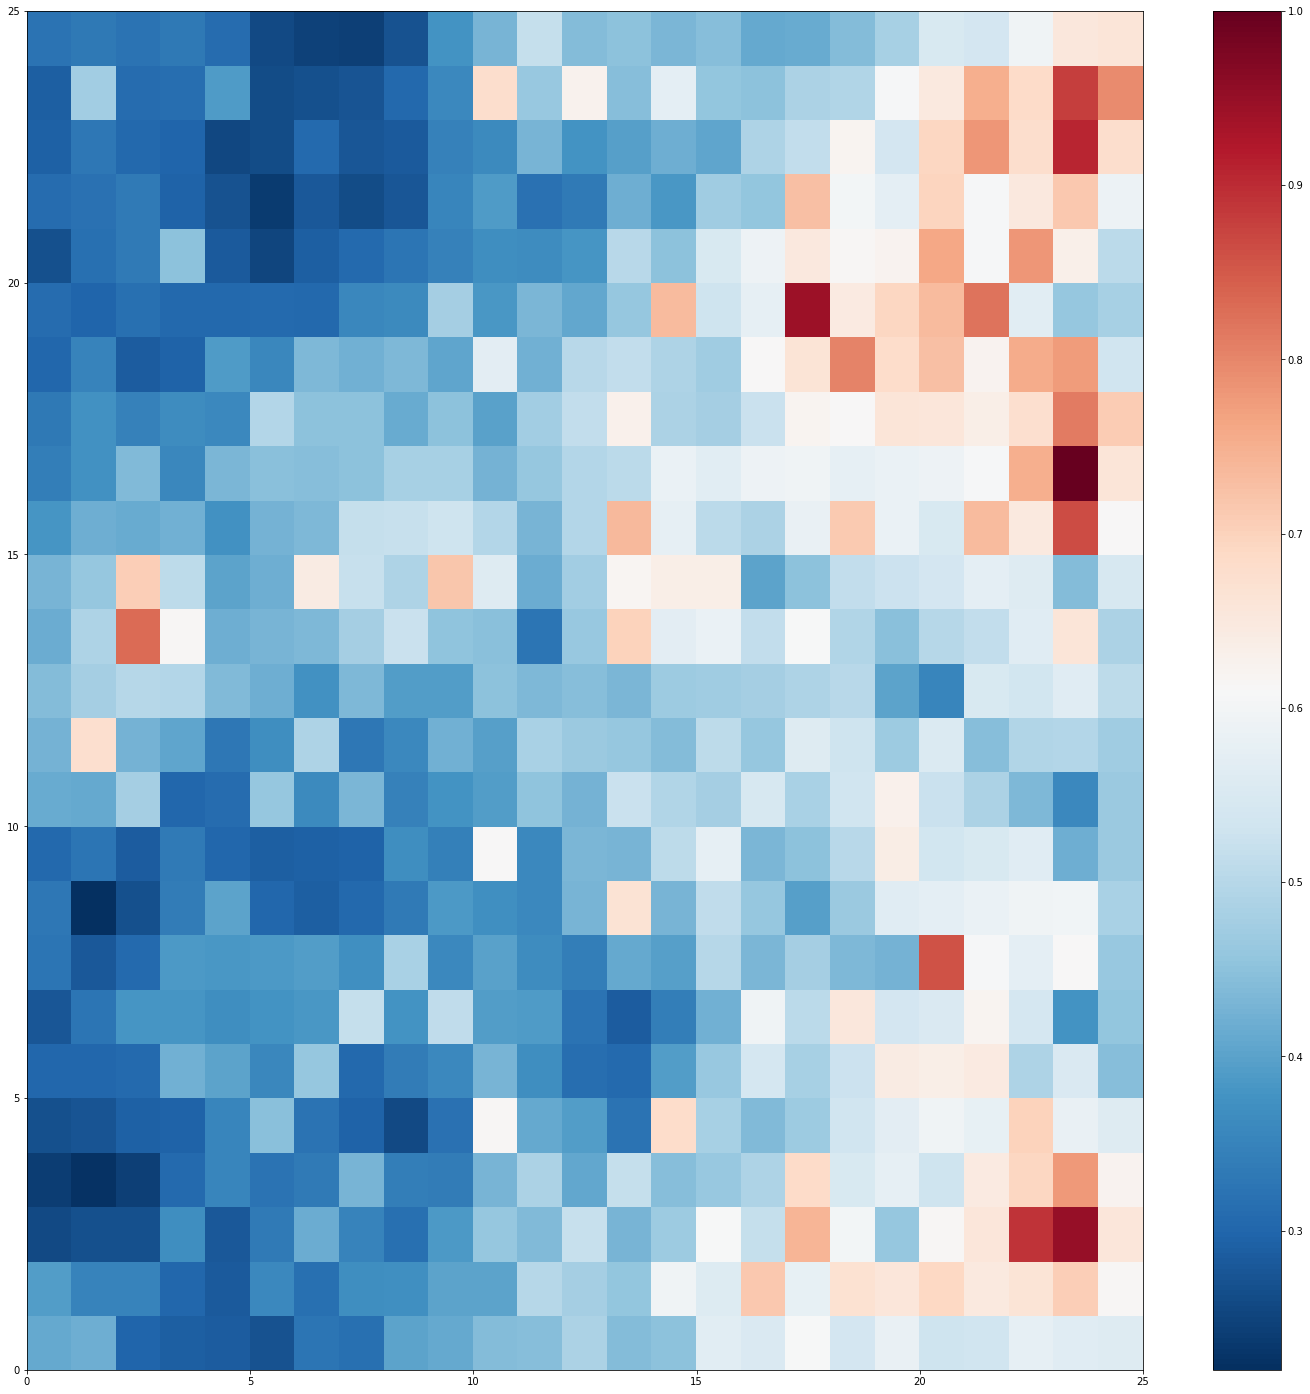

In [11]:
%matplotlib inline

plt.figure(figsize=(25, 25))

plt.pcolor(dist_map.T, cmap='RdBu_r')
plt.colorbar()

for d in x:
    w = som.winner(d)
    plt.plot(w[0]+.5, w[1]+.5)